In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import OrdinalEncoder

from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import log_loss,roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier

import xgboost as xgb

from sklearn.calibration import CalibratedClassifierCV

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

import pickle
from prettytable import PrettyTable
from tqdm import tqdm
import sys
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1.1 Reading Data

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Applied AI/CS1/in-vehicle-coupon-recommendation.csv')
data.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0


In [ ]:
print("Number of data points:", data.shape[0])
print("Number of features:", data.shape[1])
print('-'*100)
print("The attributes of data :", data.columns.values)

Number of data points: 12684
Number of features: 26
----------------------------------------------------------------------------------------------------
The attributes of data : ['destination' 'passanger' 'weather' 'temperature' 'time' 'coupon'
 'expiration' 'gender' 'age' 'maritalStatus' 'has_children' 'education'
 'occupation' 'income' 'car' 'Bar' 'CoffeeHouse' 'CarryAway'
 'RestaurantLessThan20' 'Restaurant20To50' 'toCoupon_GEQ5min'
 'toCoupon_GEQ15min' 'toCoupon_GEQ25min' 'direction_same' 'direction_opp'
 'Y']


In [ ]:
Y_value_counts = data.groupby('Y').Y.count()
print('The number of users that are accepted the coupon is ',Y_value_counts[1],',',round(Y_value_counts[1]/data.shape[0]*100,3),'%')
print('The number of users that are rejected the coupon is ',Y_value_counts[0],',',round(Y_value_counts[0]/data.shape[0]*100,3),'%')

The number of users that are accepted the coupon is  7210 , 56.843 %
The number of users that are rejected the coupon is  5474 , 43.157 %


In [ ]:
# data.info()
# data.nunique()

## 1.2 Train Test Split

In [ ]:
X = data.drop(['Y'], axis=1)
y = data['Y'].values

In [ ]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_PTA, y_train, y_PTA = train_test_split(X, y, test_size=0.20, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.20, stratify=y_train)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_PTA.shape, y_PTA.shape)

(8117, 25) (8117,)
(2030, 25) (2030,)
(2537, 25) (2537,)


In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8117 entries, 4687 to 3457
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           8117 non-null   object
 1   passanger             8117 non-null   object
 2   weather               8117 non-null   object
 3   temperature           8117 non-null   int64 
 4   time                  8117 non-null   object
 5   coupon                8117 non-null   object
 6   expiration            8117 non-null   object
 7   gender                8117 non-null   object
 8   age                   8117 non-null   object
 9   maritalStatus         8117 non-null   object
 10  has_children          8117 non-null   int64 
 11  education             8117 non-null   object
 12  occupation            8117 non-null   object
 13  income                8117 non-null   object
 14  car                   74 non-null     object
 15  Bar                   8057 non-null

In [ ]:
print('Is there any missing value present or not?',X_train.isnull().values.any())

Is there any missing value present or not? True


## 1.3 Data Cleaning

In [ ]:
# # Remove duplicates
# duplicate = data[data.duplicated(keep = 'last')]
# # duplicate.shape #(74, 26)
# data = data.drop_duplicates()
# print(data.shape)

__Missing Values__

In [ ]:
# missing values
print('Is there any missing value present or not?',data.isnull().values.any())
missing_percentage = data.isnull().sum()*100/len(data)
missing_value_df = pd.DataFrame({'missing_count': data.isnull().sum(),'missing_percentage': missing_percentage})
missing_value_df[missing_value_df.missing_count != 0]

Is there any missing value present or not? True


,missing_count,missing_percentage
car,12576,99.148534
Bar,107,0.843582
CoffeeHouse,217,1.710817
CarryAway,151,1.190476
RestaurantLessThan20,130,1.024913
Restaurant20To50,189,1.490066


* Feature 'car' has 99% of the missing value, drop this feature because even after predicting missing values, this feature has less importance, and it has less predictive power.

In [ ]:
X_train = X_train.drop(['car'], axis=1)
X_test = X_test.drop(['car'], axis=1)

__Correlation of Features__

In [ ]:
X_train.corr() #covariance matrix 

,temperature,has_children,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp
temperature,1.000000,-0.015811,NaN,-0.153307,-0.221842,0.090960,-0.090960
has_children,-0.015811,1.000000,NaN,0.087322,-0.008013,-0.030278,0.030278
toCoupon_GEQ5min,NaN,NaN,NaN,NaN,NaN,NaN,NaN
toCoupon_GEQ15min,-0.153307,0.087322,NaN,1.000000,0.315623,-0.292891,0.292891
toCoupon_GEQ25min,-0.221842,-0.008013,NaN,0.315623,1.000000,-0.186257,0.186257
direction_same,0.090960,-0.030278,NaN,-0.292891,-0.186257,1.000000,-1.000000
direction_opp,-0.090960,0.030278,NaN,0.292891,0.186257,-1.000000,1.000000


1. Feature ‘direction_same’ is perfectly correlated with ‘direction_opp’, both have the same variance.
2. ‘toCoupon_GEQ5min’ feature has no correlation with any feature because it has the same value ‘1’ for all data points, which means all the restaurants/bars are at least more than five minutes away from the driver.

so, drop both 'direction_opp' and 'toCoupon_GEQ5min' features.

In [ ]:
X_train = X_train.drop(['direction_opp','toCoupon_GEQ5min'], axis=1)
X_test = X_test.drop(['direction_opp','toCoupon_GEQ5min'], axis=1)
X_train.shape, X_test.shape

((8117, 22), (2030, 22))

In [ ]:
X_train.describe()
# data.describe(include='all')

,temperature,has_children,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same
count,8117.000000,8117.000000,8117.000000,8117.000000,8117.000000
mean,63.235801,0.419860,0.564125,0.114205,0.212024
std,19.224225,0.493566,0.495902,0.318079,0.408767
min,30.000000,0.000000,0.000000,0.000000,0.000000
25%,55.000000,0.000000,0.000000,0.000000,0.000000
50%,80.000000,0.000000,1.000000,0.000000,0.000000
75%,80.000000,1.000000,1.000000,0.000000,0.000000
max,80.000000,1.000000,1.000000,1.000000,1.000000


__Analysis of 'direction_same' feature__

In [ ]:
# Analysis of 'direction_same' feature
df = pd.DataFrame(sorted(list(data['direction_same'].unique())),columns=['direction_same'])
df['Total_Count'] = list(data.groupby('direction_same').Y.count())
df['Total_%'] = round(df['Total_Count']/data['direction_same'].shape[0]*100,3)
df['Accepted'] = list(data[data.Y==1].groupby('direction_same').Y.count())
df['Rejected'] = list(data[data.Y==0].groupby('direction_same').Y.count())
df['%Accepted'] = round(df['Accepted']/df['Total_Count']*100,3)
df['%Rejected'] = round(df['Rejected']/df['Total_Count']*100,3)
df

,direction_same,Total_Count,Total_%,Accepted,Rejected,%Accepted,%Rejected
0,0,9960,78.524,5624,4336,56.466,43.534
1,1,2724,21.476,1586,1138,58.223,41.777


In [ ]:
# X_train = X_train.drop(['direction_same'], axis=1)
# X_test = X_test.drop(['direction_same'], axis=1)
# X_train.shape, X_test.shape

* direction_same feature has 78% value is '0', and 22% value is '1'. Both value has almost similar acceptance ratio. so this feature not more usefull. So, drop 'direction_same' feature.

## 1.4 Mode Imputation

In [ ]:
# frequent_values = []
# for i in (X_train.columns.values):
#   frequent_values.append(X_train[i].value_counts().sort_values(ascending=False).index[0])

# df = pd.DataFrame(frequent_values,columns=['frequent_values'],index=X_train.columns.values)
# df.to_csv('/content/drive/MyDrive/Applied AI/CS1/frequent_values.csv')

In [ ]:
frequent_df = pd.read_csv('/content/drive/MyDrive/Applied AI/CS1/frequent_values.csv',index_col=0)

In [ ]:
# mode imputation for missing values in train data
X_train['Bar'] = X_train['Bar'].fillna(frequent_df.loc['Bar'][0])
X_train['CoffeeHouse'] = X_train['CoffeeHouse'].fillna(frequent_df.loc['CoffeeHouse'][0])
X_train['CarryAway'] = X_train['CarryAway'].fillna(frequent_df.loc['CarryAway'][0])
X_train['RestaurantLessThan20'] = X_train['RestaurantLessThan20'].fillna(frequent_df.loc['RestaurantLessThan20'][0])
X_train['Restaurant20To50'] = X_train['Restaurant20To50'].fillna(frequent_df.loc['Restaurant20To50'][0])

In [ ]:
# mode imputation for missing values in test data
X_test['Bar'] = X_test['Bar'].fillna(frequent_df.loc['Bar'][0])
X_test['CoffeeHouse'] = X_test['CoffeeHouse'].fillna(frequent_df.loc['CoffeeHouse'][0])
X_test['CarryAway'] = X_test['CarryAway'].fillna(frequent_df.loc['CarryAway'][0])
X_test['RestaurantLessThan20'] = X_test['RestaurantLessThan20'].fillna(frequent_df.loc['RestaurantLessThan20'][0])
X_test['Restaurant20To50'] = X_test['Restaurant20To50'].fillna(frequent_df.loc['Restaurant20To50'][0])

In [ ]:
print('Is there any missing value present in X_train?',X_train.isnull().values.any())

Is there any missing value present in X_train? False


In [ ]:
print('Is there any missing value present in X_test?',X_test.isnull().values.any())

Is there any missing value present in X_test? False


## 1.5 Feature Engineering

**FE** -- __to_Coupon__

In [ ]:
# FE -- to_Coupon is combination of two features, toCoupon_GEQ15min and toCoupon_GEQ25min
to_Coupon = []
for i in range(X_train.shape[0]):
    if (list(X_train['toCoupon_GEQ15min'])[i] == 0):
        to_Coupon.append(0)
    elif (list(X_train['toCoupon_GEQ15min'])[i] == 1)and(list(X_train['toCoupon_GEQ25min'])[i] == 0):
        to_Coupon.append(1)
    else:
        to_Coupon.append(2)
        
X_train['to_Coupon'] = to_Coupon
print('Unique values:',X_train['to_Coupon'].unique())
print('-'*50)
X_train['to_Coupon'].describe()

Unique values: [1 0 2]
--------------------------------------------------


count    8117.000000
mean        0.678329
std         0.668329
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         2.000000
Name: to_Coupon, dtype: float64

In [ ]:
# FE -- to_Coupon is combination of two features, toCoupon_GEQ15min and toCoupon_GEQ25min
to_Coupon = []
for i in range(X_test.shape[0]):
    if (list(X_test['toCoupon_GEQ15min'])[i] == 0):
        to_Coupon.append(0)
    elif (list(X_test['toCoupon_GEQ15min'])[i] == 1)and(list(X_test['toCoupon_GEQ25min'])[i] == 0):
        to_Coupon.append(1)
    else:
        to_Coupon.append(2)
        
X_test['to_Coupon'] = to_Coupon
print('Unique values:',X_test['to_Coupon'].unique())
print('-'*50)
X_test['to_Coupon'].describe()

Unique values: [1 0 2]
--------------------------------------------------


count    2030.000000
mean        0.677833
std         0.697564
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         2.000000
Name: to_Coupon, dtype: float64

**FE** -- __coupon_freq__

In [ ]:
# FE -- coupon_freq is combination of five features, RestaurantLessThan20, CoffeeHouse, CarryAway, Bar, Restaurant20To50
coupon_freq = []
for i in range(X_train.shape[0]):
    if (list(X_train['coupon'])[i] == 'Restaurant(<20)'):
        coupon_freq.append(list(X_train['RestaurantLessThan20'])[i])
    elif (list(X_train['coupon'])[i] == 'Coffee House'):
        coupon_freq.append(list(X_train['CoffeeHouse'])[i])
    elif (list(X_train['coupon'])[i] == 'Carry out & Take away'):
        coupon_freq.append(list(X_train['CarryAway'])[i])
    elif (list(X_train['coupon'])[i] == 'Bar'):
        coupon_freq.append(list(X_train['Bar'])[i])
    elif (list(X_train['coupon'])[i] == 'Restaurant(20-50)'):
        coupon_freq.append(list(X_train['Restaurant20To50'])[i])
        
X_train['coupon_freq'] = coupon_freq
print('Unique values:',X_train['coupon_freq'].unique())
print('-'*50)
X_train['coupon_freq'].describe()

Unique values: ['never' '1~3' '4~8' 'less1' 'gt8']
--------------------------------------------------


count     8117
unique       5
top        1~3
freq      2504
Name: coupon_freq, dtype: object

In [ ]:
# FE -- coupon_freq is combination of five features, RestaurantLessThan20, CoffeeHouse, CarryAway, Bar, Restaurant20To50
coupon_freq = []
for i in range(X_test.shape[0]):
    if (list(X_test['coupon'])[i] == 'Restaurant(<20)'):
        coupon_freq.append(list(X_test['RestaurantLessThan20'])[i])
    elif (list(X_test['coupon'])[i] == 'Coffee House'):
        coupon_freq.append(list(X_test['CoffeeHouse'])[i])
    elif (list(X_test['coupon'])[i] == 'Carry out & Take away'):
        coupon_freq.append(list(X_test['CarryAway'])[i])
    elif (list(X_test['coupon'])[i] == 'Bar'):
        coupon_freq.append(list(X_test['Bar'])[i])
    elif (list(X_test['coupon'])[i] == 'Restaurant(20-50)'):
        coupon_freq.append(list(X_test['Restaurant20To50'])[i])
        
X_test['coupon_freq'] = coupon_freq
print('Unique values:',X_test['coupon_freq'].unique()) 
print('-'*50)
X_test['coupon_freq'].describe()

Unique values: ['never' '4~8' 'gt8' '1~3' 'less1']
--------------------------------------------------


count     2030
unique       5
top        1~3
freq       617
Name: coupon_freq, dtype: object

**FE** -- __occupation_class__

In [ ]:
X_train['occupation'].describe()

count           8117
unique            25
top       Unemployed
freq            1172
Name: occupation, dtype: object

In [ ]:
# occupation feature has 25 no of distinct values, which creates very sparsity in data after Encoding
# FE -- occupation_class where categorize all occupation in its suitable class.
occupation_dict = {'Healthcare Support':'High_Acceptance','Construction & Extraction':'High_Acceptance','Healthcare Practitioners & Technical':'High_Acceptance',
                   'Protective Service':'High_Acceptance','Architecture & Engineering':'High_Acceptance','Production Occupations':'Medium_High_Acceptance',
                    'Student':'Medium_High_Acceptance','Office & Administrative Support':'Medium_High_Acceptance','Transportation & Material Moving':'Medium_High_Acceptance',
                    'Building & Grounds Cleaning & Maintenance':'Medium_High_Acceptance','Management':'Medium_Acceptance','Food Preparation & Serving Related':'Medium_Acceptance',
                   'Life Physical Social Science':'Medium_Acceptance','Business & Financial':'Medium_Acceptance','Computer & Mathematical':'Medium_Acceptance',
                    'Sales & Related':'Medium_Low_Acceptance','Personal Care & Service':'Medium_Low_Acceptance','Unemployed':'Medium_Low_Acceptance',
                   'Farming Fishing & Forestry':'Medium_Low_Acceptance','Installation Maintenance & Repair':'Medium_Low_Acceptance','Education&Training&Library':'Low_Acceptance',
                    'Arts Design Entertainment Sports & Media':'Low_Acceptance','Community & Social Services':'Low_Acceptance','Legal':'Low_Acceptance','Retired':'Low_Acceptance'}
# occupation_dict
X_train['occupation_class'] = X_train['occupation'].map(occupation_dict)
print('Unique values:',X_train['occupation_class'].unique())
print('-'*50)
X_train['occupation_class'].describe()
# X_train['occupation_class'].value_counts()

Unique values: ['Low_Acceptance' 'Medium_Acceptance' 'Medium_Low_Acceptance'
 'Medium_High_Acceptance' 'High_Acceptance']
--------------------------------------------------


count                  8117
unique                    5
top       Medium_Acceptance
freq                   2097
Name: occupation_class, dtype: object

In [ ]:
X_test['occupation'].describe()

count           2030
unique            25
top       Unemployed
freq             317
Name: occupation, dtype: object

In [ ]:
# occupation feature has 25 no of distinct values, which creates very sparsity in data after Encoding
# FE -- occupation_class where categorize all occupation in its suitable class.
occupation_dict = {'Healthcare Support':'High_Acceptance','Construction & Extraction':'High_Acceptance','Healthcare Practitioners & Technical':'High_Acceptance',
                   'Protective Service':'High_Acceptance','Architecture & Engineering':'High_Acceptance','Production Occupations':'Medium_High_Acceptance',
                    'Student':'Medium_High_Acceptance','Office & Administrative Support':'Medium_High_Acceptance','Transportation & Material Moving':'Medium_High_Acceptance',
                    'Building & Grounds Cleaning & Maintenance':'Medium_High_Acceptance','Management':'Medium_Acceptance','Food Preparation & Serving Related':'Medium_Acceptance',
                   'Life Physical Social Science':'Medium_Acceptance','Business & Financial':'Medium_Acceptance','Computer & Mathematical':'Medium_Acceptance',
                    'Sales & Related':'Medium_Low_Acceptance','Personal Care & Service':'Medium_Low_Acceptance','Unemployed':'Medium_Low_Acceptance',
                   'Farming Fishing & Forestry':'Medium_Low_Acceptance','Installation Maintenance & Repair':'Medium_Low_Acceptance','Education&Training&Library':'Low_Acceptance',
                    'Arts Design Entertainment Sports & Media':'Low_Acceptance','Community & Social Services':'Low_Acceptance','Legal':'Low_Acceptance','Retired':'Low_Acceptance'}
# occupation_dict
X_test['occupation_class'] = X_test['occupation'].map(occupation_dict)
print('Unique values:',X_test['occupation_class'].unique())
print('-'*50)
X_test['occupation_class'].describe()
# X_test['occupation_class'].value_counts()

Unique values: ['Medium_Low_Acceptance' 'Medium_Acceptance' 'Low_Acceptance'
 'Medium_High_Acceptance' 'High_Acceptance']
--------------------------------------------------


count                      2030
unique                        5
top       Medium_Low_Acceptance
freq                        551
Name: occupation_class, dtype: object

In [ ]:
# After Feature Engineering, removing unwanted features
X_train = X_train.drop(['occupation'], axis=1)
X_test = X_test.drop(['occupation'], axis=1)
print('X_train:',X_train.shape,'\nX_test:',X_test.shape)
print('-'*50)
print(X_train.columns.values)

X_train: (8117, 24) 
X_test: (2030, 24)
--------------------------------------------------
['destination' 'passanger' 'weather' 'temperature' 'time' 'coupon'
 'expiration' 'gender' 'age' 'maritalStatus' 'has_children' 'education'
 'income' 'Bar' 'CoffeeHouse' 'CarryAway' 'RestaurantLessThan20'
 'Restaurant20To50' 'toCoupon_GEQ15min' 'toCoupon_GEQ25min'
 'direction_same' 'to_Coupon' 'coupon_freq' 'occupation_class']


In [ ]:
X_train.columns.values

array(['destination', 'passanger', 'weather', 'temperature', 'time',
       'coupon', 'expiration', 'gender', 'age', 'maritalStatus',
       'has_children', 'education', 'income', 'Bar', 'CoffeeHouse',
       'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50',
       'toCoupon_GEQ15min', 'toCoupon_GEQ25min', 'direction_same',
       'to_Coupon', 'coupon_freq', 'occupation_class'], dtype=object)

## 1.6 Ordinal Encoding

In [ ]:
order = [['Work','Home','No Urgent Place'],['Kid(s)','Alone','Partner','Friend(s)'],['Rainy','Snowy','Sunny'],[30,55,80],['7AM','10AM','2PM','6PM','10PM'],
         ['Bar','Restaurant(20-50)','Coffee House','Restaurant(<20)','Carry out & Take away'],['2h','1d'],['Female','Male'],['below21','21','26','31','36','41','46','50plus'],
         ['Widowed','Divorced','Married partner','Unmarried partner','Single'],[0,1],
         ['Some High School','High School Graduate','Some college - no degree','Associates degree','Bachelors degree','Graduate degree (Masters or Doctorate)'],
         ['Less than $12500','$12500 - $24999','$25000 - $37499','$37500 - $49999','$50000 - $62499','$62500 - $74999','$75000 - $87499','$87500 - $99999','$100000 or More'],
         ['never','less1','1~3','4~8','gt8'],['never','less1','1~3','4~8','gt8'],['never','less1','1~3','4~8','gt8'],['never','less1','1~3','4~8','gt8'],['never','less1','1~3','4~8','gt8'],
         [0,1],[0,1],[0,1],[0,1,2],['never','less1','1~3','4~8','gt8'],['Low_Acceptance','Medium_Low_Acceptance','Medium_Acceptance','Medium_High_Acceptance','High_Acceptance']]

In [ ]:
Ordinal_enc = OrdinalEncoder(categories=order)
# save trained model
# pickle.dump(Ordinal_enc, open("/content/drive/MyDrive/Applied AI/CS1/Ordinal_enc.pkl", "wb"))

In [ ]:
Ordinal_enc = OrdinalEncoder(categories=order)
X_train_Ordinal_encoding = Ordinal_enc.fit_transform(X_train)
X_train_Ordinal_encoding = pd.DataFrame(X_train_Ordinal_encoding,columns=X_train.columns.values)
print('X_train_Ordinal_encoding:',X_train_Ordinal_encoding.shape)

X_train_Ordinal_encoding: (8117, 24)


In [ ]:
Ordinal_enc = OrdinalEncoder(categories=order)
X_test_Ordinal_encoding = Ordinal_enc.fit_transform(X_test)
X_test_Ordinal_encoding = pd.DataFrame(X_test_Ordinal_encoding,columns=X_test.columns.values)
print('X_test_Ordinal_encoding:',X_test_Ordinal_encoding.shape)

X_test_Ordinal_encoding: (2030, 24)


## 1.7 Stacking Classifier Model

In [ ]:
estimators = [('GNB', GaussianNB()),
                ('LR', LogisticRegression(random_state=42,C=100)),
                ('KNN', KNeighborsClassifier(n_neighbors=21)),
                ('DT', DecisionTreeClassifier(class_weight='balanced', max_depth=10, min_samples_split=100, random_state=42)),
                ('LSVC',LinearSVC(C=1,random_state=42)),
                ('SVC', SVC(C=10,kernel='rbf',class_weight='balanced',probability=True)),
                ('GBC',GradientBoostingClassifier(n_estimators=500, learning_rate=1.0,max_depth=5, random_state=42)),
                ('RF',RandomForestClassifier(n_estimators=2000,criterion='gini',max_depth=20,max_features='log2',min_samples_leaf=3, random_state=42, n_jobs=-1)),
                ('HGB', HistGradientBoostingClassifier()),
                ('BC',BaggingClassifier(base_estimator=DecisionTreeClassifier(),n_estimators=2000,random_state=42)),
                ('ABC',AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),n_estimators=1000,learning_rate=0.1,random_state=42)),
                ('ETC',ExtraTreesClassifier(n_estimators=500, random_state=42)),
                ('XGB', xgb.XGBClassifier(max_depth=10, n_estimators=500, random_state=42))]

Stacking_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
Stacking_model.fit(X_train_Ordinal_encoding, y_train)

Train_loss = log_loss(y_train,Stacking_model.predict_proba(X_train_Ordinal_encoding))
Train_AUC = roc_auc_score(y_train,(Stacking_model.predict_proba(X_train_Ordinal_encoding))[:,1])
Test_loss = log_loss(y_test,Stacking_model.predict_proba(X_test_Ordinal_encoding))
Test_AUC = roc_auc_score(y_test,(Stacking_model.predict_proba(X_test_Ordinal_encoding))[:,1])

In [ ]:
summary_table = PrettyTable(["Model","Encoding", "Train_log_loss", "Train_roc_auc_score", "Test_log_loss", "Test_roc_auc_score"]) #heading
summary_table.add_row(["Stacking Classifier","Ordinal Encoding",round(Train_loss,3),round(Train_AUC,3),round(Test_loss,3),round(Test_AUC,3)])
table = pd.read_html(summary_table.get_html_string())
Stacking_Classifier_Result = table[0]
Stacking_Classifier_Result

,Model,Encoding,Train_log_loss,Train_roc_auc_score,Test_log_loss,Test_roc_auc_score
0,Stacking Classifier,Ordinal Encoding,0.167,1.0,0.506,0.829


In [ ]:
# # save trained model
# pickle.dump(Stacking_model, open("/content/drive/MyDrive/Applied AI/CS1/Stacking_model.pkl", "wb"))
# Stacking_model = pickle.load(open("/content/drive/MyDrive/Applied AI/CS1/Stacking_model.pkl", "rb"))

## 1.8 Data Pipeline

In [ ]:
def final_1(X,model):
  # print(X.shape)
  X = X.drop(['car','direction_opp','toCoupon_GEQ5min'], axis=1)
  # print(X.shape)

  # print('Is there any missing value present in data point?',X.isnull().values.any())
  # mode imputation for missing values in data point
  frequent_df = pd.read_csv('/content/drive/MyDrive/Applied AI/CS1/frequent_values.csv',index_col=0)
  for i in (X.columns.values):
    if (X[i].isnull().values.any()):
      X[i] = X[i].fillna(frequent_df.loc[i][0])
  # print('Is there any missing value present in data point?',X.isnull().values.any())
  # print(X.shape)

  # FE
  if (list(X['toCoupon_GEQ15min'])[0] == 0):
    X['to_Coupon'] = 0
  elif (list(X['toCoupon_GEQ15min'])[0] == 1)and(list(X['toCoupon_GEQ25min'])[0] == 0):
    X['to_Coupon'] = 1
  else:
    X['to_Coupon'] = 2
  # print(X['to_Coupon'])

  if (list(X['coupon'])[0] == 'Restaurant(<20)'):
        X['coupon_freq'] = (list(X['RestaurantLessThan20'])[0])
  elif (list(X['coupon'])[0] == 'Coffee House'):
        X['coupon_freq'] = (list(X['CoffeeHouse'])[0])
  elif (list(X['coupon'])[0] == 'Carry out & Take away'):
        X['coupon_freq'] = (list(X['CarryAway'])[0])
  elif (list(X['coupon'])[0] == 'Bar'):
        X['coupon_freq'] = (list(X['Bar'])[0])
  elif (list(X['coupon'])[0] == 'Restaurant(20-50)'):
        X['coupon_freq'] = (list(X['Restaurant20To50'])[0])
  # print(X['coupon_freq'])

  occupation_dict = {'Healthcare Support':'High_Acceptance','Construction & Extraction':'High_Acceptance','Healthcare Practitioners & Technical':'High_Acceptance',
                   'Protective Service':'High_Acceptance','Architecture & Engineering':'High_Acceptance','Production Occupations':'Medium_High_Acceptance',
                    'Student':'Medium_High_Acceptance','Office & Administrative Support':'Medium_High_Acceptance','Transportation & Material Moving':'Medium_High_Acceptance',
                    'Building & Grounds Cleaning & Maintenance':'Medium_High_Acceptance','Management':'Medium_Acceptance','Food Preparation & Serving Related':'Medium_Acceptance',
                   'Life Physical Social Science':'Medium_Acceptance','Business & Financial':'Medium_Acceptance','Computer & Mathematical':'Medium_Acceptance',
                    'Sales & Related':'Medium_Low_Acceptance','Personal Care & Service':'Medium_Low_Acceptance','Unemployed':'Medium_Low_Acceptance',
                   'Farming Fishing & Forestry':'Medium_Low_Acceptance','Installation Maintenance & Repair':'Medium_Low_Acceptance','Education&Training&Library':'Low_Acceptance',
                    'Arts Design Entertainment Sports & Media':'Low_Acceptance','Community & Social Services':'Low_Acceptance','Legal':'Low_Acceptance','Retired':'Low_Acceptance'}
  X['occupation_class'] = X['occupation'].map(occupation_dict)
  # print(X['occupation_class'])

  # print(X.shape)
  
  X = X.drop(['occupation'], axis=1)
  # print(X.shape)

  order = [['Work','Home','No Urgent Place'],['Kid(s)','Alone','Partner','Friend(s)'],['Rainy','Snowy','Sunny'],[30,55,80],['7AM','10AM','2PM','6PM','10PM'],
         ['Bar','Restaurant(20-50)','Coffee House','Restaurant(<20)','Carry out & Take away'],['2h','1d'],['Female','Male'],['below21','21','26','31','36','41','46','50plus'],
         ['Widowed','Divorced','Married partner','Unmarried partner','Single'],[0,1],
         ['Some High School','High School Graduate','Some college - no degree','Associates degree','Bachelors degree','Graduate degree (Masters or Doctorate)'],
         ['Less than $12500','$12500 - $24999','$25000 - $37499','$37500 - $49999','$50000 - $62499','$62500 - $74999','$75000 - $87499','$87500 - $99999','$100000 or More'],
         ['never','less1','1~3','4~8','gt8'],['never','less1','1~3','4~8','gt8'],['never','less1','1~3','4~8','gt8'],['never','less1','1~3','4~8','gt8'],['never','less1','1~3','4~8','gt8'],
         [0,1],[0,1],[0,1],[0,1,2],['never','less1','1~3','4~8','gt8'],['Low_Acceptance','Medium_Low_Acceptance','Medium_Acceptance','Medium_High_Acceptance','High_Acceptance']]
  Ordinal_enc = OrdinalEncoder(categories=order)
  # Ordinal_enc = pickle.load(open("/content/drive/MyDrive/Applied AI/CS1/Ordinal_enc.pkl", "rb"))
  X_Ordinal_encoding = Ordinal_enc.fit_transform(X)
  X_Ordinal_encoding = pd.DataFrame(X_Ordinal_encoding,columns=X.columns.values)
  # print(X_Ordinal_encoding.shape)
  # print(X_Ordinal_encoding.head())

  # load trained model
  # model = pickle.load(open("/content/drive/MyDrive/Applied AI/CS1/Stacking_model.pkl", "rb"))
  y_pred = model.predict(X_Ordinal_encoding)
  y_pred_prob = model.predict_proba(X_Ordinal_encoding)
  # print('Predicted output:',y_pred[0])

  return y_pred[0], y_pred_prob[0], X, X_Ordinal_encoding

# Predicted_output, Predicted_prob, X, X_OE = final_1(X_datapoint,Stacking_model)
# print('Predicted output for given datapoint is',Predicted_output)
# print('Predicted probability for given datapoint is',Predicted_prob)

In [ ]:
from sklearn.metrics import log_loss,roc_auc_score
def final_2(X_set,y_set,model):
  Y_predict = []
  Y_predict_prob = []
  X_data = []
  X_OE_data = []
  for i in tqdm(range(X_set.shape[0])):
    df = pd.DataFrame([(X_set.iloc[i]).values],columns=(X_set.iloc[i]).index)
    y_pred, y_pred_prob, X, X_OE = final_1(df,model)
    Y_predict.append(y_pred)
    Y_predict_prob.append(y_pred_prob)
    X_data.append(np.array(X.iloc[0]))
    X_OE_data.append(np.array(X_OE.iloc[0]))
  # print(len(Y_predict)) # 2537
  
  logloss = log_loss(y_set,np.array(Y_predict_prob))
  AUC_Score = roc_auc_score(y_set,np.array(Y_predict_prob)[:,1])
  X_data = pd.DataFrame(X_data,columns=X.columns.values)
  X_OE_data = pd.DataFrame(X_OE_data,columns=X_OE.columns.values)
  
  return logloss, AUC_Score, np.array(Y_predict), X_data, X_OE_data

# logloss, AUC_Score, Y_predict, X_data, X_OE_data = final_2(X_PTA.head(3),y_PTA[:3],Stacking_model)

logloss, AUC_Score, Y_predict, X_data, X_OE_data = final_2(X_PTA,y_PTA,Stacking_model)
print('\nTest log loss:',logloss,'\nTest AUC Score:',AUC_Score)
# print(Y_predict.shape, X_data.shape, X_OE_data.shape)

100%|██████████| 2537/2537 [1:04:49<00:00,  1.53s/it]

Test log loss: 0.49827510470969233 
Test AUC Score: 0.8311331927371295


In [ ]:
X_data['Y'] = y_PTA
X_data['Y_predict'] = Y_predict

confusion_matrix = []
for i in range(X_data.shape[0]):
  if (list(X_data['Y'])[i] == 1) and (list(X_data['Y_predict'])[i] == 1):
    confusion_matrix.append('TP')
  elif (list(X_data['Y'])[i] == 0) and (list(X_data['Y_predict'])[i] == 0):
    confusion_matrix.append('TN')
  elif (list(X_data['Y'])[i] == 0) and (list(X_data['Y_predict'])[i] == 1):
    confusion_matrix.append('FP')
  elif (list(X_data['Y'])[i] == 1) and (list(X_data['Y_predict'])[i] == 0):
    confusion_matrix.append('FN')
# print(len(confusion_matrix))
X_data['confusion_matrix'] = confusion_matrix
# print(X_data.shape)

X_data_TP = X_data[X_data.confusion_matrix == 'TP']
X_data_TN = X_data[X_data.confusion_matrix == 'TN']
X_data_FP = X_data[X_data.confusion_matrix == 'FP']
X_data_FN = X_data[X_data.confusion_matrix == 'FN']
print(X_data_TP.shape, X_data_TN.shape, X_data_FP.shape, X_data_FN.shape)

from sklearn.metrics import confusion_matrix
confusion_matrix(X_data['Y'], X_data['Y_predict'])

(1209, 27) (735, 27) (360, 27) (233, 27)


array([[ 735,  360],
       [ 233, 1209]])

In [ ]:
# X_data.to_csv('/content/drive/MyDrive/Applied AI/CS1/X_data_final.csv')

## 1.9 Post Training Analysis

In [ ]:
from tabulate import tabulate
def post_training_analysis(column_name,data=X_data):
    df_EDA = pd.DataFrame(sorted(list(data[column_name].unique())),columns=[column_name])
    df_EDA['Total_Count'] = list(data.groupby(column_name).Y.count())
    df_EDA['TP'] = df_EDA[column_name].map(data[data.confusion_matrix=='TP'].groupby(column_name).confusion_matrix.count())
    df_EDA['TN'] = df_EDA[column_name].map(data[data.confusion_matrix=='TN'].groupby(column_name).confusion_matrix.count())
    df_EDA['FP'] = df_EDA[column_name].map(data[data.confusion_matrix=='FP'].groupby(column_name).confusion_matrix.count())
    df_EDA['FN'] = df_EDA[column_name].map(data[data.confusion_matrix=='FN'].groupby(column_name).confusion_matrix.count())
    df_EDA['%TP'] = round(df_EDA['TP']/df_EDA['Total_Count']*100,3)
    df_EDA['%TN'] = round(df_EDA['TN']/df_EDA['Total_Count']*100,3)
    df_EDA['%FP'] = round(df_EDA['FP']/df_EDA['Total_Count']*100,3)
    df_EDA['%FN'] = round(df_EDA['FN']/df_EDA['Total_Count']*100,3)
    df_EDA['Tsum'] = df_EDA['%TP']+df_EDA['%TN']
    df_EDA = df_EDA.sort_values(by='Tsum', ascending=False)
    df_EDA = df_EDA.drop(['Tsum'],axis=1)

    fig,ax = plt.subplots(figsize =(15, 4))
    sns.countplot(x=X_data[column_name],hue=X_data['confusion_matrix'])
    ax.set_title('Post Training Analysis of '+column_name)
    plt.show()
    print(tabulate(df_EDA,headers='keys',tablefmt='psql'))
    return df_EDA

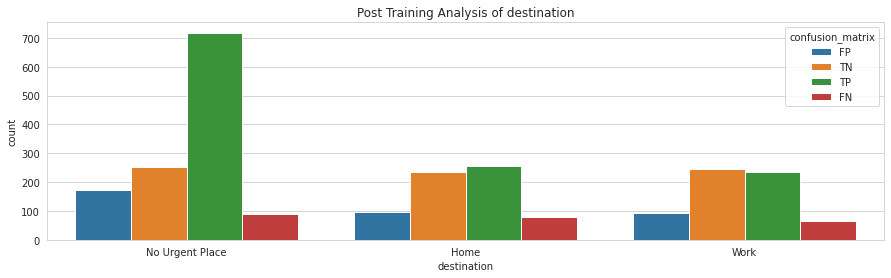

+----+-----------------+---------------+------+------+------+------+--------+--------+--------+--------+
|    | destination     |   Total_Count |   TP |   TN |   FP |   FN |    %TP |    %TN |    %FP |    %FN |
|----+-----------------+---------------+------+------+------+------+--------+--------+--------+--------|
|  1 | No Urgent Place |          1231 |  718 |  254 |  171 |   88 | 58.327 | 20.634 | 13.891 |  7.149 |
|  2 | Work            |           638 |  235 |  245 |   92 |   66 | 36.834 | 38.401 | 14.42  | 10.345 |
|  0 | Home            |           668 |  256 |  236 |   97 |   79 | 38.323 | 35.329 | 14.521 | 11.826 |
+----+-----------------+---------------+------+------+------+------+--------+--------+--------+--------+

 ******************************************************************************************************************************************************


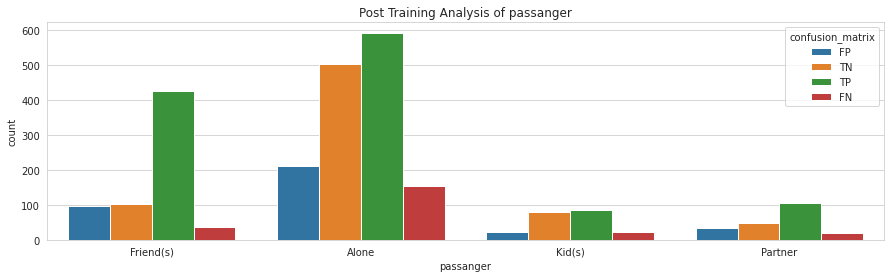

+----+-------------+---------------+------+------+------+------+--------+--------+--------+--------+
|    | passanger   |   Total_Count |   TP |   TN |   FP |   FN |    %TP |    %TN |    %FP |    %FN |
|----+-------------+---------------+------+------+------+------+--------+--------+--------+--------|
|  1 | Friend(s)   |           660 |  426 |  102 |   96 |   36 | 64.545 | 15.455 | 14.545 |  5.455 |
|  2 | Kid(s)      |           208 |   84 |   81 |   21 |   22 | 40.385 | 38.942 | 10.096 | 10.577 |
|  0 | Alone       |          1461 |  593 |  503 |  210 |  155 | 40.589 | 34.428 | 14.374 | 10.609 |
|  3 | Partner     |           208 |  106 |   49 |   33 |   20 | 50.962 | 23.558 | 15.865 |  9.615 |
+----+-------------+---------------+------+------+------+------+--------+--------+--------+--------+

 ******************************************************************************************************************************************************


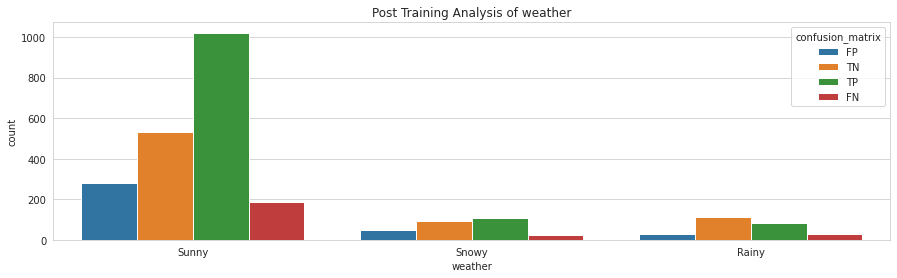

+----+-----------+---------------+------+------+------+------+--------+--------+--------+--------+
|    | weather   |   Total_Count |   TP |   TN |   FP |   FN |    %TP |    %TN |    %FP |    %FN |
|----+-----------+---------------+------+------+------+------+--------+--------+--------+--------|
|  2 | Sunny     |          2016 | 1021 |  530 |  281 |  184 | 50.645 | 26.29  | 13.938 |  9.127 |
|  0 | Rainy     |           251 |   82 |  111 |   31 |   27 | 32.669 | 44.223 | 12.351 | 10.757 |
|  1 | Snowy     |           270 |  106 |   94 |   48 |   22 | 39.259 | 34.815 | 17.778 |  8.148 |
+----+-----------+---------------+------+------+------+------+--------+--------+--------+--------+

 ******************************************************************************************************************************************************


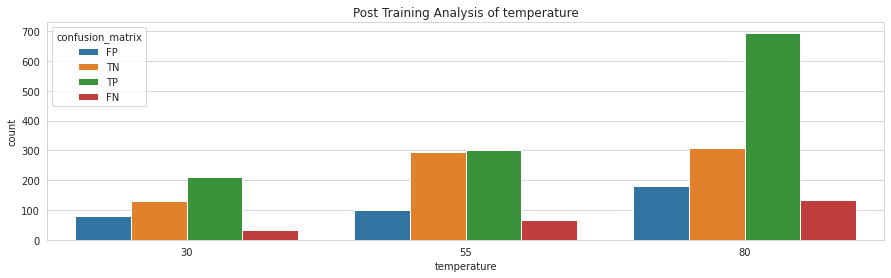

+----+---------------+---------------+------+------+------+------+--------+--------+--------+--------+
|    |   temperature |   Total_Count |   TP |   TN |   FP |   FN |    %TP |    %TN |    %FP |    %FN |
|----+---------------+---------------+------+------+------+------+--------+--------+--------+--------|
|  1 |            55 |           764 |  303 |  295 |  100 |   66 | 39.66  | 38.613 | 13.089 |  8.639 |
|  2 |            80 |          1319 |  695 |  309 |  181 |  134 | 52.691 | 23.427 | 13.723 | 10.159 |
|  0 |            30 |           454 |  211 |  131 |   79 |   33 | 46.476 | 28.855 | 17.401 |  7.269 |
+----+---------------+---------------+------+------+------+------+--------+--------+--------+--------+

 ******************************************************************************************************************************************************


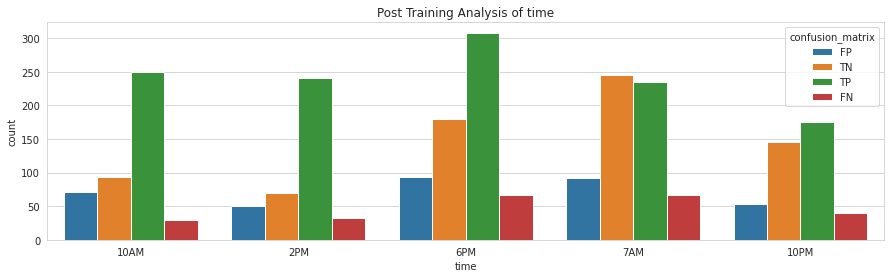

+----+--------+---------------+------+------+------+------+--------+--------+--------+--------+
|    | time   |   Total_Count |   TP |   TN |   FP |   FN |    %TP |    %TN |    %FP |    %FN |
|----+--------+---------------+------+------+------+------+--------+--------+--------+--------|
|  2 | 2PM    |           393 |  241 |   70 |   50 |   32 | 61.323 | 17.812 | 12.723 |  8.142 |
|  1 | 10PM   |           414 |  175 |  146 |   53 |   40 | 42.271 | 35.266 | 12.802 |  9.662 |
|  0 | 10AM   |           444 |  250 |   94 |   71 |   29 | 56.306 | 21.171 | 15.991 |  6.532 |
|  3 | 6PM    |           648 |  308 |  180 |   94 |   66 | 47.531 | 27.778 | 14.506 | 10.185 |
|  4 | 7AM    |           638 |  235 |  245 |   92 |   66 | 36.834 | 38.401 | 14.42  | 10.345 |
+----+--------+---------------+------+------+------+------+--------+--------+--------+--------+

 **************************************************************************************************************************************

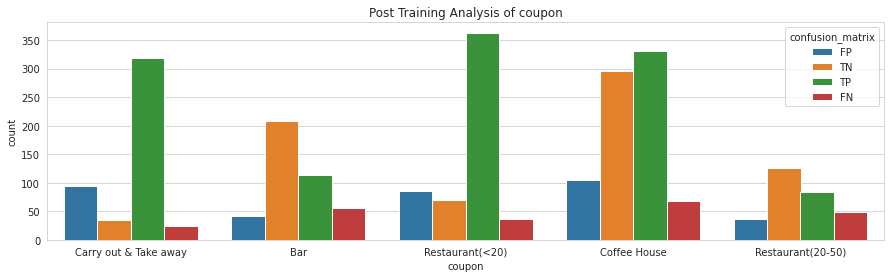

+----+-----------------------+---------------+------+------+------+------+--------+--------+--------+--------+
|    | coupon                |   Total_Count |   TP |   TN |   FP |   FN |    %TP |    %TN |    %FP |    %FN |
|----+-----------------------+---------------+------+------+------+------+--------+--------+--------+--------|
|  2 | Coffee House          |           799 |  331 |  296 |  104 |   68 | 41.427 | 37.046 | 13.016 |  8.511 |
|  4 | Restaurant(<20)       |           554 |  363 |   70 |   85 |   36 | 65.523 | 12.635 | 15.343 |  6.498 |
|  0 | Bar                   |           419 |  114 |  209 |   41 |   55 | 27.208 | 49.881 |  9.785 | 13.126 |
|  1 | Carry out & Take away |           472 |  318 |   35 |   94 |   25 | 67.373 |  7.415 | 19.915 |  5.297 |
|  3 | Restaurant(20-50)     |           293 |   83 |  125 |   36 |   49 | 28.328 | 42.662 | 12.287 | 16.724 |
+----+-----------------------+---------------+------+------+------+------+--------+--------+--------+--------+



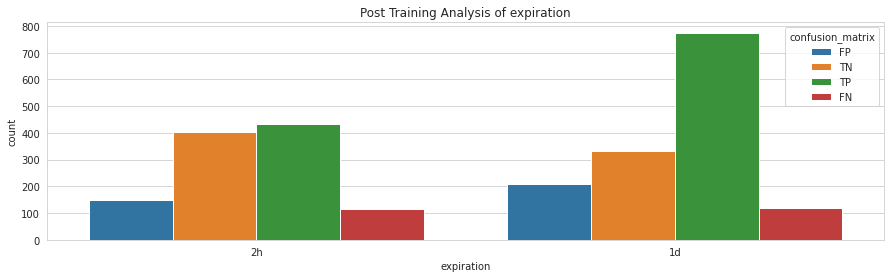

+----+--------------+---------------+------+------+------+------+--------+--------+--------+--------+
|    | expiration   |   Total_Count |   TP |   TN |   FP |   FN |    %TP |    %TN |    %FP |    %FN |
|----+--------------+---------------+------+------+------+------+--------+--------+--------+--------|
|  0 | 1d           |          1435 |  775 |  332 |  210 |  118 | 54.007 | 23.136 | 14.634 |  8.223 |
|  1 | 2h           |          1102 |  434 |  403 |  150 |  115 | 39.383 | 36.57  | 13.612 | 10.436 |
+----+--------------+---------------+------+------+------+------+--------+--------+--------+--------+

 ******************************************************************************************************************************************************


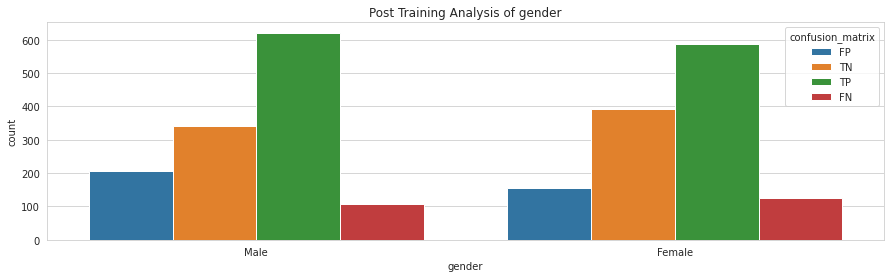

+----+----------+---------------+------+------+------+------+--------+--------+--------+-------+
|    | gender   |   Total_Count |   TP |   TN |   FP |   FN |    %TP |    %TN |    %FP |   %FN |
|----+----------+---------------+------+------+------+------+--------+--------+--------+-------|
|  0 | Female   |          1261 |  588 |  393 |  154 |  126 | 46.63  | 31.166 | 12.213 | 9.992 |
|  1 | Male     |          1276 |  621 |  342 |  206 |  107 | 48.668 | 26.803 | 16.144 | 8.386 |
+----+----------+---------------+------+------+------+------+--------+--------+--------+-------+

 ******************************************************************************************************************************************************


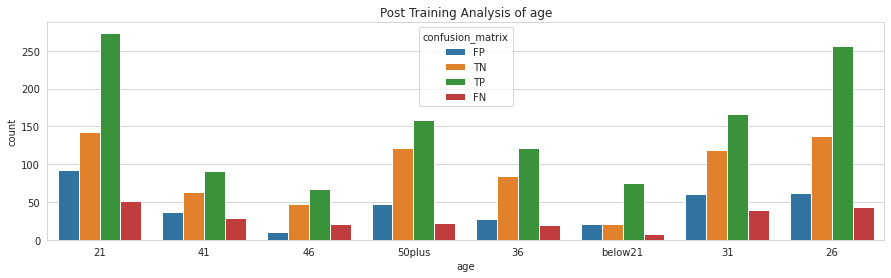

+----+---------+---------------+------+------+------+------+--------+--------+--------+--------+
|    | age     |   Total_Count |   TP |   TN |   FP |   FN |    %TP |    %TN |    %FP |    %FN |
|----+---------+---------------+------+------+------+------+--------+--------+--------+--------|
|  3 | 36      |           252 |  121 |   84 |   28 |   19 | 48.016 | 33.333 | 11.111 |  7.54  |
|  6 | 50plus  |           351 |  159 |  122 |   48 |   22 | 45.299 | 34.758 | 13.675 |  6.268 |
|  1 | 26      |           498 |  256 |  137 |   62 |   43 | 51.406 | 27.51  | 12.45  |  8.635 |
|  5 | 46      |           145 |   67 |   47 |   10 |   21 | 46.207 | 32.414 |  6.897 | 14.483 |
|  7 | below21 |           125 |   75 |   21 |   21 |    8 | 60     | 16.8   | 16.8   |  6.4   |
|  0 | 21      |           560 |  274 |  142 |   93 |   51 | 48.929 | 25.357 | 16.607 |  9.107 |
|  2 | 31      |           386 |  166 |  119 |   61 |   40 | 43.005 | 30.829 | 15.803 | 10.363 |
|  4 | 41      |           220

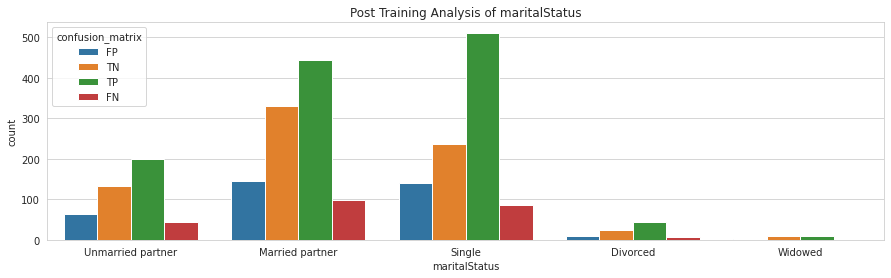

+----+-------------------+---------------+------+------+------+------+--------+--------+--------+---------+
|    | maritalStatus     |   Total_Count |   TP |   TN |   FP |   FN |    %TP |    %TN |    %FP |     %FN |
|----+-------------------+---------------+------+------+------+------+--------+--------+--------+---------|
|  4 | Widowed           |            20 |    9 |   10 |    1 |  nan | 45     | 50     |  5     | nan     |
|  0 | Divorced          |            87 |   45 |   25 |    9 |    8 | 51.724 | 28.736 | 10.345 |   9.195 |
|  2 | Single            |           973 |  511 |  236 |  141 |   85 | 52.518 | 24.255 | 14.491 |   8.736 |
|  1 | Married partner   |          1018 |  444 |  331 |  146 |   97 | 43.615 | 32.515 | 14.342 |   9.528 |
|  3 | Unmarried partner |           439 |  200 |  133 |   63 |   43 | 45.558 | 30.296 | 14.351 |   9.795 |
+----+-------------------+---------------+------+------+------+------+--------+--------+--------+---------+

 **************************

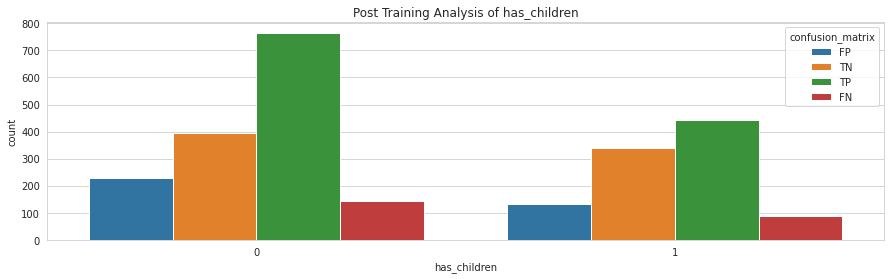

+----+----------------+---------------+------+------+------+------+--------+--------+--------+-------+
|    |   has_children |   Total_Count |   TP |   TN |   FP |   FN |    %TP |    %TN |    %FP |   %FN |
|----+----------------+---------------+------+------+------+------+--------+--------+--------+-------|
|  1 |              1 |          1005 |  444 |  341 |  132 |   88 | 44.179 | 33.93  | 13.134 | 8.756 |
|  0 |              0 |          1532 |  765 |  394 |  228 |  145 | 49.935 | 25.718 | 14.883 | 9.465 |
+----+----------------+---------------+------+------+------+------+--------+--------+--------+-------+

 ******************************************************************************************************************************************************


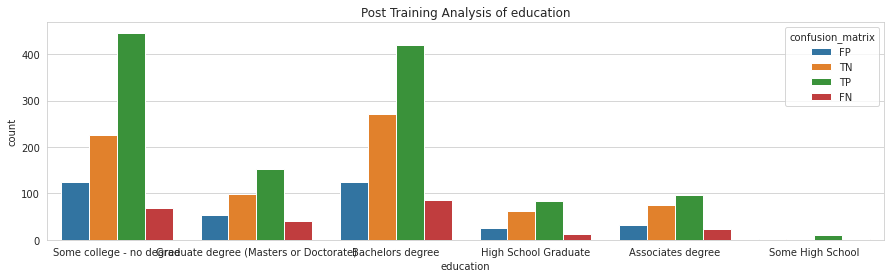

+----+----------------------------------------+---------------+------+------+------+------+--------+--------+--------+--------+
|    | education                              |   Total_Count |   TP |   TN |   FP |   FN |    %TP |    %TN |    %FP |    %FN |
|----+----------------------------------------+---------------+------+------+------+------+--------+--------+--------+--------|
|  3 | High School Graduate                   |           184 |   84 |   62 |   25 |   13 | 45.652 | 33.696 | 13.587 |  7.065 |
|  5 | Some college - no degree               |           865 |  446 |  225 |  125 |   69 | 51.561 | 26.012 | 14.451 |  7.977 |
|  1 | Bachelors degree                       |           900 |  419 |  272 |  124 |   85 | 46.556 | 30.222 | 13.778 |  9.444 |
|  0 | Associates degree                      |           227 |   97 |   76 |   31 |   23 | 42.731 | 33.48  | 13.656 | 10.132 |
|  4 | Some High School                       |            16 |   10 |    2 |    2 |    2 | 62.5   | 12.

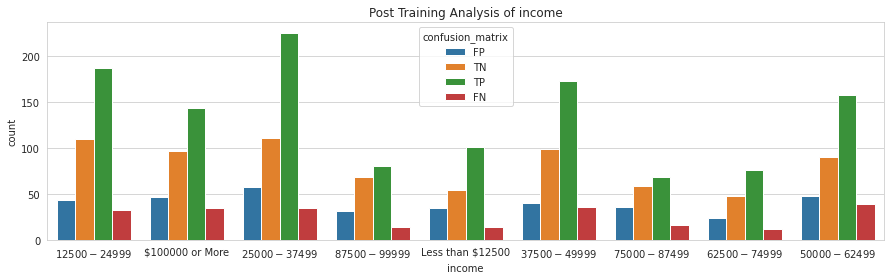

+----+------------------+---------------+------+------+------+------+--------+--------+--------+--------+
|    | income           |   Total_Count |   TP |   TN |   FP |   FN |    %TP |    %TN |    %FP |    %FN |
|----+------------------+---------------+------+------+------+------+--------+--------+--------+--------|
|  1 | $12500 - $24999  |           372 |  187 |  110 |   43 |   32 | 50.269 | 29.57  | 11.559 |  8.602 |
|  2 | $25000 - $37499  |           428 |  225 |  111 |   57 |   35 | 52.57  | 25.935 | 13.318 |  8.178 |
|  3 | $37500 - $49999  |           347 |  172 |   99 |   40 |   36 | 49.568 | 28.53  | 11.527 | 10.375 |
|  5 | $62500 - $74999  |           160 |   76 |   48 |   24 |   12 | 47.5   | 30     | 15     |  7.5   |
|  7 | $87500 - $99999  |           193 |   80 |   68 |   31 |   14 | 41.451 | 35.233 | 16.062 |  7.254 |
|  8 | Less than $12500 |           204 |  101 |   54 |   35 |   14 | 49.51  | 26.471 | 17.157 |  6.863 |
|  0 | $100000 or More  |           321 |  143

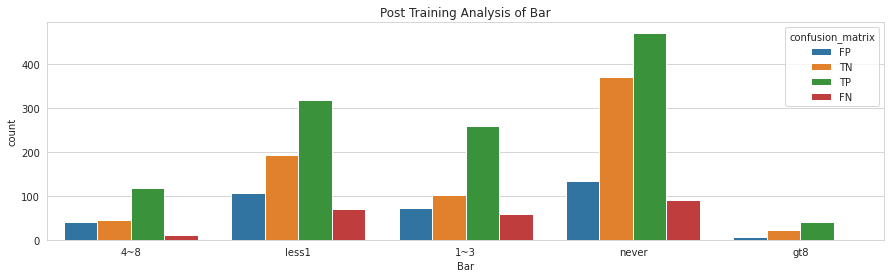

+----+-------+---------------+------+------+------+------+--------+--------+--------+--------+
|    | Bar   |   Total_Count |   TP |   TN |   FP |   FN |    %TP |    %TN |    %FP |    %FN |
|----+-------+---------------+------+------+------+------+--------+--------+--------+--------|
|  2 | gt8   |            72 |   41 |   23 |    7 |    1 | 56.944 | 31.944 |  9.722 |  1.389 |
|  4 | never |          1069 |  472 |  371 |  135 |   91 | 44.153 | 34.705 | 12.629 |  8.513 |
|  1 | 4~8   |           213 |  117 |   44 |   40 |   12 | 54.93  | 20.657 | 18.779 |  5.634 |
|  3 | less1 |           689 |  319 |  194 |  106 |   70 | 46.299 | 28.157 | 15.385 | 10.16  |
|  0 | 1~3   |           494 |  260 |  103 |   72 |   59 | 52.632 | 20.85  | 14.575 | 11.943 |
+----+-------+---------------+------+------+------+------+--------+--------+--------+--------+

 ***********************************************************************************************************************************************

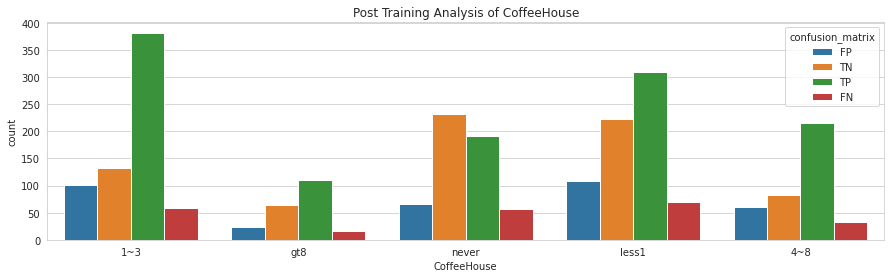

+----+---------------+---------------+------+------+------+------+--------+--------+--------+--------+
|    | CoffeeHouse   |   Total_Count |   TP |   TN |   FP |   FN |    %TP |    %TN |    %FP |    %FN |
|----+---------------+---------------+------+------+------+------+--------+--------+--------+--------|
|  2 | gt8           |           215 |  111 |   65 |   23 |   16 | 51.628 | 30.233 | 10.698 |  7.442 |
|  4 | never         |           547 |  192 |  232 |   66 |   57 | 35.101 | 42.413 | 12.066 | 10.42  |
|  0 | 1~3           |           675 |  382 |  133 |  102 |   58 | 56.593 | 19.704 | 15.111 |  8.593 |
|  1 | 4~8           |           390 |  215 |   82 |   60 |   33 | 55.128 | 21.026 | 15.385 |  8.462 |
|  3 | less1         |           710 |  309 |  223 |  109 |   69 | 43.521 | 31.408 | 15.352 |  9.718 |
+----+---------------+---------------+------+------+------+------+--------+--------+--------+--------+

 ***********************************************************************

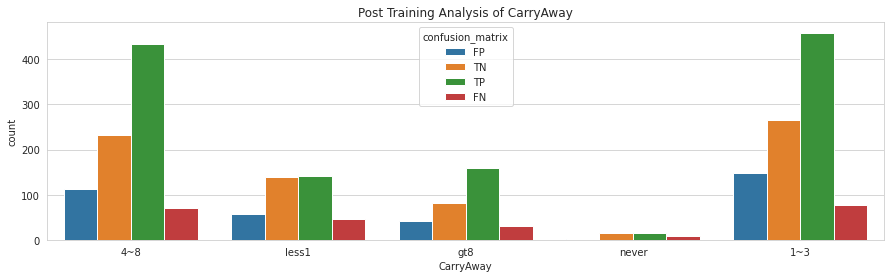

+----+-------------+---------------+------+------+------+------+--------+--------+--------+--------+
|    | CarryAway   |   Total_Count |   TP |   TN |   FP |   FN |    %TP |    %TN |    %FP |    %FN |
|----+-------------+---------------+------+------+------+------+--------+--------+--------+--------|
|  1 | 4~8         |           849 |  433 |  233 |  112 |   71 | 51.001 | 27.444 | 13.192 |  8.363 |
|  2 | gt8         |           313 |  160 |   82 |   41 |   30 | 51.118 | 26.198 | 13.099 |  9.585 |
|  0 | 1~3         |           950 |  459 |  266 |  148 |   77 | 48.316 | 28     | 15.579 |  8.105 |
|  4 | never       |            41 |   16 |   15 |    2 |    8 | 39.024 | 36.585 |  4.878 | 19.512 |
|  3 | less1       |           384 |  141 |  139 |   57 |   47 | 36.719 | 36.198 | 14.844 | 12.24  |
+----+-------------+---------------+------+------+------+------+--------+--------+--------+--------+

 *****************************************************************************************

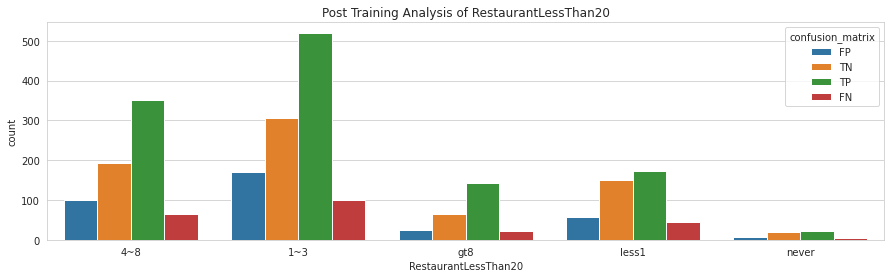

+----+------------------------+---------------+------+------+------+------+--------+--------+--------+--------+
|    | RestaurantLessThan20   |   Total_Count |   TP |   TN |   FP |   FN |    %TP |    %TN |    %FP |    %FN |
|----+------------------------+---------------+------+------+------+------+--------+--------+--------+--------|
|  2 | gt8                    |           254 |  142 |   66 |   25 |   21 | 55.906 | 25.984 |  9.843 |  8.268 |
|  4 | never                  |            54 |   22 |   20 |    8 |    4 | 40.741 | 37.037 | 14.815 |  7.407 |
|  1 | 4~8                    |           710 |  351 |  194 |  101 |   64 | 49.437 | 27.324 | 14.225 |  9.014 |
|  3 | less1                  |           425 |  174 |  150 |   57 |   44 | 40.941 | 35.294 | 13.412 | 10.353 |
|  0 | 1~3                    |          1094 |  520 |  305 |  169 |  100 | 47.532 | 27.879 | 15.448 |  9.141 |
+----+------------------------+---------------+------+------+------+------+--------+--------+--------+--

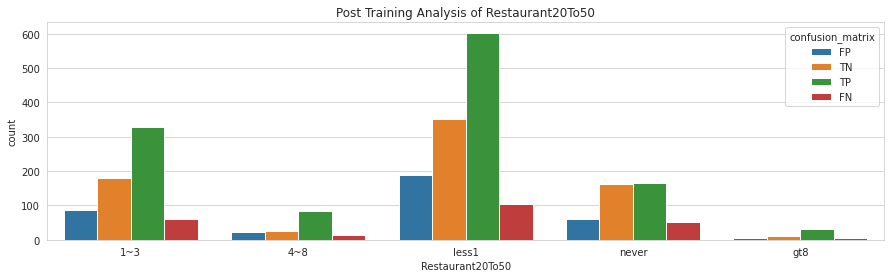

+----+--------------------+---------------+------+------+------+------+--------+--------+--------+--------+
|    | Restaurant20To50   |   Total_Count |   TP |   TN |   FP |   FN |    %TP |    %TN |    %FP |    %FN |
|----+--------------------+---------------+------+------+------+------+--------+--------+--------+--------|
|  2 | gt8                |            51 |   31 |   12 |    4 |    4 | 60.784 | 23.529 |  7.843 |  7.843 |
|  0 | 1~3                |           654 |  327 |  180 |   86 |   61 | 50     | 27.523 | 13.15  |  9.327 |
|  3 | less1              |          1247 |  603 |  353 |  188 |  103 | 48.356 | 28.308 | 15.076 |  8.26  |
|  1 | 4~8                |           146 |   83 |   27 |   22 |   14 | 56.849 | 18.493 | 15.068 |  9.589 |
|  4 | never              |           439 |  165 |  163 |   60 |   51 | 37.585 | 37.13  | 13.667 | 11.617 |
+----+--------------------+---------------+------+------+------+------+--------+--------+--------+--------+

 **************************

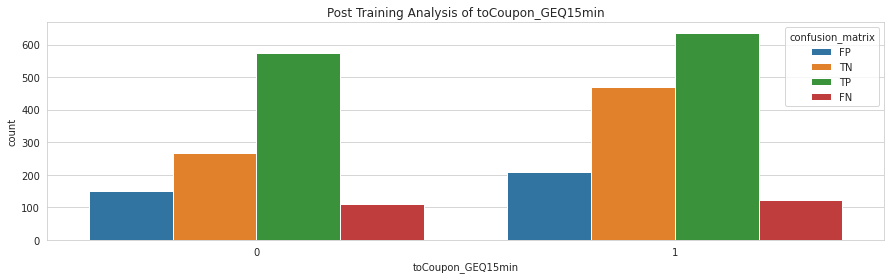

+----+---------------------+---------------+------+------+------+------+--------+--------+--------+-------+
|    |   toCoupon_GEQ15min |   Total_Count |   TP |   TN |   FP |   FN |    %TP |    %TN |    %FP |   %FN |
|----+---------------------+---------------+------+------+------+------+--------+--------+--------+-------|
|  1 |                   1 |          1439 |  636 |  469 |  210 |  124 | 44.197 | 32.592 | 14.593 | 8.617 |
|  0 |                   0 |          1098 |  573 |  266 |  150 |  109 | 52.186 | 24.226 | 13.661 | 9.927 |
+----+---------------------+---------------+------+------+------+------+--------+--------+--------+-------+

 ******************************************************************************************************************************************************


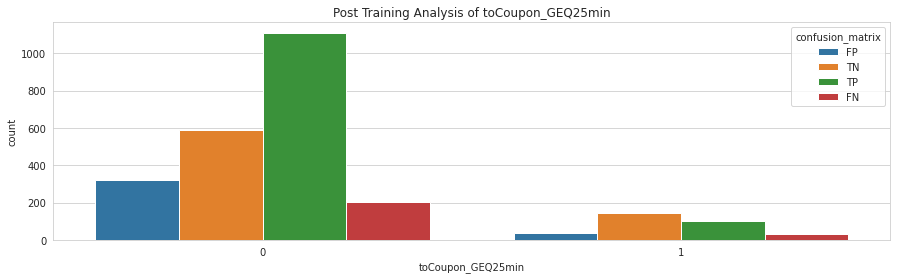

+----+---------------------+---------------+------+------+------+------+--------+--------+--------+-------+
|    |   toCoupon_GEQ25min |   Total_Count |   TP |   TN |   FP |   FN |    %TP |    %TN |    %FP |   %FN |
|----+---------------------+---------------+------+------+------+------+--------+--------+--------+-------|
|  1 |                   1 |           312 |  100 |  144 |   37 |   31 | 32.051 | 46.154 | 11.859 | 9.936 |
|  0 |                   0 |          2225 | 1109 |  591 |  323 |  202 | 49.843 | 26.562 | 14.517 | 9.079 |
+----+---------------------+---------------+------+------+------+------+--------+--------+--------+-------+

 ******************************************************************************************************************************************************


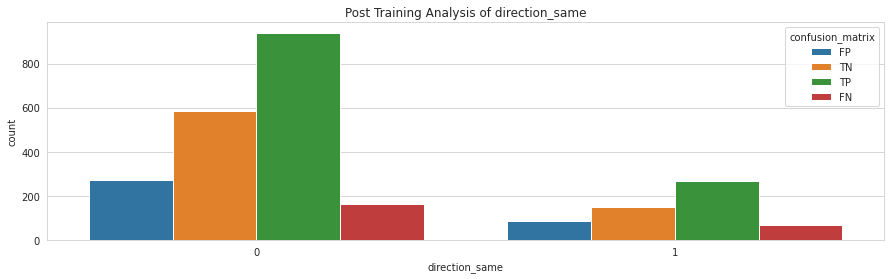

+----+------------------+---------------+------+------+------+------+--------+--------+--------+--------+
|    |   direction_same |   Total_Count |   TP |   TN |   FP |   FN |    %TP |    %TN |    %FP |    %FN |
|----+------------------+---------------+------+------+------+------+--------+--------+--------+--------|
|  0 |                0 |          1963 |  940 |  584 |  274 |  165 | 47.886 | 29.75  | 13.958 |  8.406 |
|  1 |                1 |           574 |  269 |  151 |   86 |   68 | 46.864 | 26.307 | 14.983 | 11.847 |
+----+------------------+---------------+------+------+------+------+--------+--------+--------+--------+

 ******************************************************************************************************************************************************


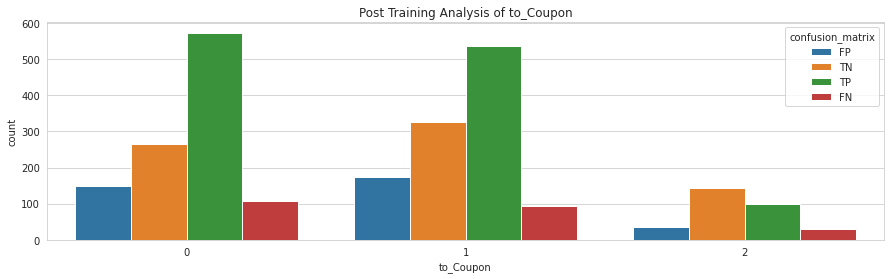

+----+-------------+---------------+------+------+------+------+--------+--------+--------+-------+
|    |   to_Coupon |   Total_Count |   TP |   TN |   FP |   FN |    %TP |    %TN |    %FP |   %FN |
|----+-------------+---------------+------+------+------+------+--------+--------+--------+-------|
|  2 |           2 |           312 |  100 |  144 |   37 |   31 | 32.051 | 46.154 | 11.859 | 9.936 |
|  0 |           0 |          1098 |  573 |  266 |  150 |  109 | 52.186 | 24.226 | 13.661 | 9.927 |
|  1 |           1 |          1127 |  536 |  325 |  173 |   93 | 47.56  | 28.838 | 15.35  | 8.252 |
+----+-------------+---------------+------+------+------+------+--------+--------+--------+-------+

 ******************************************************************************************************************************************************


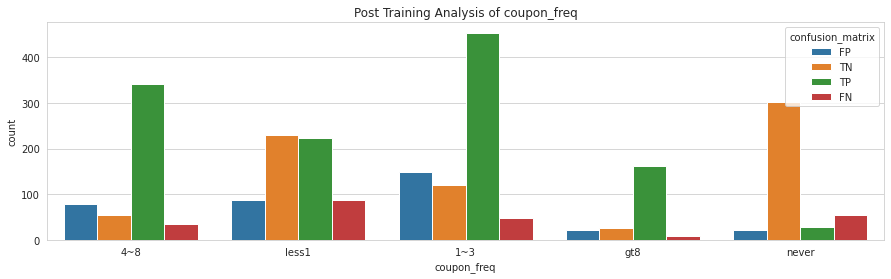

+----+---------------+---------------+------+------+------+------+--------+--------+--------+--------+
|    | coupon_freq   |   Total_Count |   TP |   TN |   FP |   FN |    %TP |    %TN |    %FP |    %FN |
|----+---------------+---------------+------+------+------+------+--------+--------+--------+--------|
|  2 | gt8           |           221 |  163 |   27 |   22 |    9 | 73.756 | 12.217 |  9.955 |  4.072 |
|  4 | never         |           407 |   28 |  303 |   22 |   54 |  6.88  | 74.447 |  5.405 | 13.268 |
|  1 | 4~8           |           510 |  341 |   55 |   79 |   35 | 66.863 | 10.784 | 15.49  |  6.863 |
|  0 | 1~3           |           771 |  454 |  120 |  149 |   48 | 58.885 | 15.564 | 19.326 |  6.226 |
|  3 | less1         |           628 |  223 |  230 |   88 |   87 | 35.51  | 36.624 | 14.013 | 13.854 |
+----+---------------+---------------+------+------+------+------+--------+--------+--------+--------+

 ***********************************************************************

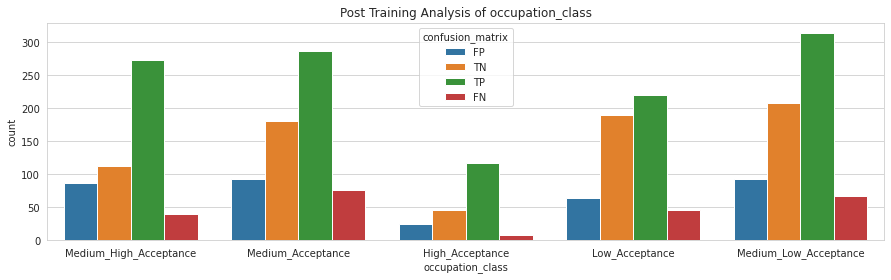

+----+------------------------+---------------+------+------+------+------+--------+--------+--------+--------+
|    | occupation_class       |   Total_Count |   TP |   TN |   FP |   FN |    %TP |    %TN |    %FP |    %FN |
|----+------------------------+---------------+------+------+------+------+--------+--------+--------+--------|
|  0 | High_Acceptance        |           193 |  116 |   46 |   24 |    7 | 60.104 | 23.834 | 12.435 |  3.627 |
|  1 | Low_Acceptance         |           518 |  220 |  189 |   64 |   45 | 42.471 | 36.486 | 12.355 |  8.687 |
|  4 | Medium_Low_Acceptance  |           680 |  314 |  207 |   93 |   66 | 46.176 | 30.441 | 13.676 |  9.706 |
|  3 | Medium_High_Acceptance |           511 |  273 |  112 |   87 |   39 | 53.425 | 21.918 | 17.025 |  7.632 |
|  2 | Medium_Acceptance      |           635 |  286 |  181 |   92 |   76 | 45.039 | 28.504 | 14.488 | 11.969 |
+----+------------------------+---------------+------+------+------+------+--------+--------+--------+--

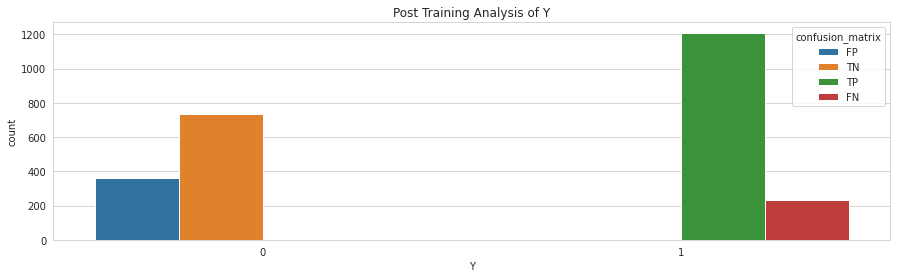

+----+-----+---------------+------+------+------+------+---------+---------+---------+---------+
|    |   Y |   Total_Count |   TP |   TN |   FP |   FN |     %TP |     %TN |     %FP |     %FN |
|----+-----+---------------+------+------+------+------+---------+---------+---------+---------|
|  0 |   0 |          1095 |  nan |  735 |  360 |  nan | nan     |  67.123 |  32.877 | nan     |
|  1 |   1 |          1442 | 1209 |  nan |  nan |  233 |  83.842 | nan     | nan     |  16.158 |
+----+-----+---------------+------+------+------+------+---------+---------+---------+---------+

 ******************************************************************************************************************************************************


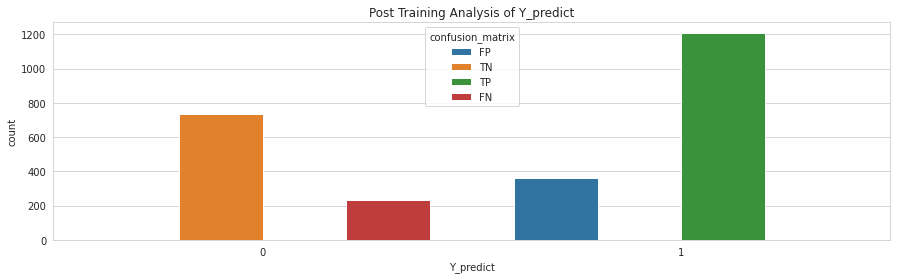

+----+-------------+---------------+------+------+------+------+---------+--------+---------+--------+
|    |   Y_predict |   Total_Count |   TP |   TN |   FP |   FN |     %TP |    %TN |     %FP |    %FN |
|----+-------------+---------------+------+------+------+------+---------+--------+---------+--------|
|  0 |           0 |           968 |  nan |  735 |  nan |  233 | nan     |  75.93 | nan     |  24.07 |
|  1 |           1 |          1569 | 1209 |  nan |  360 |  nan |  77.055 | nan    |  22.945 | nan    |
+----+-------------+---------------+------+------+------+------+---------+--------+---------+--------+

 ******************************************************************************************************************************************************


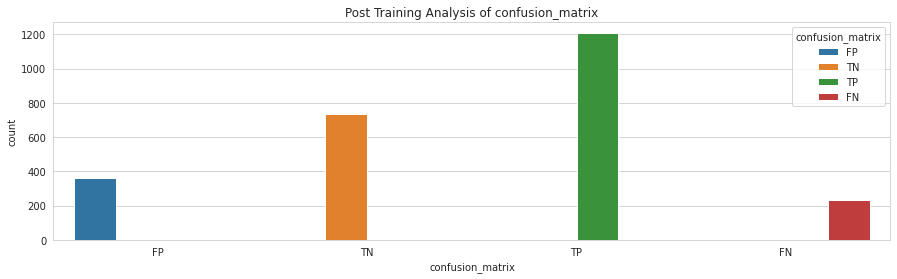

+----+--------------------+---------------+------+------+------+------+-------+-------+-------+-------+
|    | confusion_matrix   |   Total_Count |   TP |   TN |   FP |   FN |   %TP |   %TN |   %FP |   %FN |
|----+--------------------+---------------+------+------+------+------+-------+-------+-------+-------|
|  0 | FN                 |           233 |  nan |  nan |  nan |  233 |   nan |   nan |   nan |   100 |
|  1 | FP                 |           360 |  nan |  nan |  360 |  nan |   nan |   nan |   100 |   nan |
|  2 | TN                 |           735 |  nan |  735 |  nan |  nan |   nan |   100 |   nan |   nan |
|  3 | TP                 |          1209 | 1209 |  nan |  nan |  nan |   100 |   nan |   nan |   nan |
+----+--------------------+---------------+------+------+------+------+-------+-------+-------+-------+

 ******************************************************************************************************************************************************


In [ ]:
for col in X_data.columns.values:
  post_training_analysis(col)
  print('\n','*'*150)

__Observations:__
* From 2537 data points, 593 data points are incorrectly classified which means approx 23% of data points are wrong predicted. From that, approx 14% of data points are False Positive and approx 9% of data points are False Negative.
* The data points that have the highest True Positives have also the chance of highest False Positives and those data points that have the lowest True Negative have also the chance of lowest False Negatives.
* The false-positive rate is high when data points are for inactive or not engaged users, like, when a destination is No Urgent Place, when a passenger is Friends or partner or kids, when the weather is Sunny, when the temperature is 80F which is normal, and when time is 10 AM and 2 PM.
* In the age feature, 21 or below 21 age users have the highest FP rate, and 30plus age users have the highest FN rate.
* Every coupon types have a high FP rate, but from that 'Carry out & Take away' coupon has the highest FP rate due to this coupon having a high acceptance rate than others.
* In the coupon_freq feature, is 4to8 data point has the highest False Positive rate.
* The false-negative rate is high when data points are unusual or for engaged users, like, when a destination is Work or Home, when a passenger is Alone, when weather is Rainy or Snowy, when the temperature is 30F or 55F which is very low, when time is 7 AM or 10 PM, when coupon type is expensive Restaurant(20-50) or Bar, when coupon expiration is 2h which is very low expiration time, when age is 30plus, when to_Coupon is 2 which means restaurant or cafe is more than 25 min away from the user.  
* Every datapoints prediction depends on the number of total data points present in the dataset.
* Improve model accuracy, need to create new features, and required more information or more no of data points.